In [1]:
import pandas as pd
import numpy as np
import random
import re, json, datetime, pytz
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import itertools

np.random.seed(0)
random.seed(0)

In [2]:
def get_data(text,return_day_count=False,return_hour_count=False):
    with open(text, 'r',encoding="utf8") as f:
        retweet_count,month,day,hour,followers,place,title,time = [],[],[],[],[],[],[], []
        pst_tz = pytz.timezone('US/Pacific') 
        for line in f:
            tweet = json.loads(line)
            retweet_count.append(tweet['metrics']['citations']['total']) 
            month.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz).month)
            day.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz).day)
            hour.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz).hour)
            followers.append(tweet['author']['followers'])
            time.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz))
            place.append(tweet['tweet']['user']['location'])
            title.append(tweet['title'])
    
    dic = {'retweet_count':retweet_count,'month':month,'day':day,'hour':hour,
    'followers':followers,'time':time,'place':place,'title':title}
    df = pd.DataFrame(dic)
    day_count = np.array(month)*31 + np.array(day) - 44
    hour_count = (day_count-1)*24 + np.array(hour)
    if return_day_count:
        df['day_count'] = day_count
    if return_hour_count:
        df['hour_count'] = hour_count
    return df   

In [3]:
superbowl = get_data('tweets_data/tweets_#superbowl.txt')
massachusetts = ['massachusetts', 'boston', 'foxborough', 'ma']
washington = ['washington','seattle','kirkland','wa','wash']

superbowl['place_id']=None
any_in = lambda a, b:not set(a).isdisjoint(b)
for i in range(len(superbowl)):
    place_list = re.sub('[^a-zA-Z]', ' ', superbowl.loc[i,'place']).lower().split(' ')
    if any_in(place_list, massachusetts):
        superbowl.loc[i, 'place_id'] = 1
    elif any_in(place_list, washington):
        superbowl.loc[i, 'place_id'] = 0

wash_mass = superbowl[superbowl['place_id']>=0]
wash_mass = wash_mass.reset_index()

stop_words = text.ENGLISH_STOP_WORDS
corpus = []
ps = PorterStemmer()
for i in range(len(wash_mass)):
    text = re.sub('[^a-zA-Z]', ' ', wash_mass.loc[i,'title']).lower().split()
    text = [ps.stem(word) for word in text if not word in stop_words]
    text = ' '.join(text)
    corpus.append(text)
      
y = wash_mass['place_id'].tolist()

In [4]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(corpus,y,test_size=0.2,random_state=0)
tfidf = TfidfVectorizer(min_df=5)
tfidf_matrix_train = tfidf.fit_transform(X_train_raw).toarray()
tfidf_matrix_test = tfidf.transform(X_test_raw).toarray()

svd = TruncatedSVD(n_components = 50, random_state = 0)
X_train = svd.fit_transform(tfidf_matrix_train)
X_test = svd.transform(tfidf_matrix_test)

In [5]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

class_names = ['Washington', 'Massachusetts']
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)

In [6]:
def find_best_grid(classifier, name):
    
    if name == 'lr':
        parameters = {"C":[10.0**x for x in np.arange(-3,3)], "penalty":["l1","l2"]}    
        
    elif name == 'knn':
        parameters = {'n_neighbors': np.arange(5, 20, 1)}
        
    elif name == 'nb':
        parameters = {'var_smoothing': [0.00000001, 0.000000001, 0.00000001]}
        
    elif name == 'rf':
        parameters = {
                      'max_depth': np.arange(1, 11, 2), 
                      'n_estimators': np.arange(100, 201, 25),
                      'max_features': ['auto', 'sqrt', 'log2'],
                      'criterion' :['gini', 'entropy']} 
        
    elif name == 'mlp':
        parameters = {'solver': ['adam'],
                      'max_iter': [50,100,200,300], 
                      'alpha': [10.0**x for x in np.arange(-3,3)], 
                      'hidden_layer_sizes': np.arange(11, 31, 5),
                      'activation': ['tanh', 'relu']}
    
    elif name == 'svm_clf':
        parameters = {'gamma': [1,0.1,0.01,0.001]}
        
    best_grid = GridSearchCV(classifier, parameters, cv=5, n_jobs=-1, verbose=True)  
    best_grid.fit(X_train, y_train)
    
    return best_grid.best_params_
        

In [7]:
from sklearn.linear_model import LogisticRegression
import time

#Logistic Regression
time_start =time.time()
lr = LogisticRegression(random_state=0, solver='liblinear')
result = find_best_grid(lr, 'lr')
print('LR best parameters is', result)
print('\nTime to run code: {}'.format(time.time()-time_start))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
LR best parameters is {'C': 1.0, 'penalty': 'l1'}

Time to run code: 7.717547655105591


In [8]:
from sklearn.neighbors import KNeighborsClassifier

#KNN Classifier
time_start =time.time()
knn = KNeighborsClassifier()
result = find_best_grid(knn, 'knn')
print('KNN best parameters is', result)
print('\nTime to run code: {}'.format(time.time()-time_start))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
KNN best parameters is {'n_neighbors': 16}

Time to run code: 226.71790528297424


In [9]:
from sklearn.naive_bayes import GaussianNB

#Naive Bayes Classifier
time_start =time.time()
nb = GaussianNB()
result = find_best_grid(nb, 'nb')
print('NB best parameters is', result)
print('\nTime to run code: {}'.format(time.time()-time_start))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
NB best parameters is {'var_smoothing': 1e-08}

Time to run code: 0.7966427803039551


In [10]:
from sklearn.ensemble import RandomForestClassifier

#Random Forest Classifier 
time_start =time.time()
rf = RandomForestClassifier(random_state=0)
result = find_best_grid(rf, 'rf')
print('RF best parameters is', result)
print('\nTime to run code: {}'.format(time.time()-time_start))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
RF best parameters is {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 125}

Time to run code: 2818.709670305252


In [11]:
from sklearn.neural_network import MLPClassifier

#Neural network classifier
time_start =time.time()
mlp = MLPClassifier(random_state=0)
result = find_best_grid(mlp, 'mlp')
print('MLP best parameters is', result)
print('\nTime to run code: {}'.format(time.time()-time_start))

Fitting 5 folds for each of 192 candidates, totalling 960 fits
MLP best parameters is {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 26, 'max_iter': 50, 'solver': 'adam'}

Time to run code: 1115.4766728878021


C:\Users\ericz\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
from sklearn import svm

#Soft margin SVM
time_start =time.time()
svm_clf = svm.SVC(probability=True, random_state=0)
result = find_best_grid(svm_clf, 'svm_clf')
print('SVM best parameters is', result)
print('\nTime to run code: {}'.format(time.time()-time_start))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
SVM best parameters is {'gamma': 1}

Time to run code: 6092.645364284515


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def best_clf_plot(clf, name):
    plt.grid(zorder=0)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
      
    plt.plot(fpr,tpr)
    plt.title('ROC curve for {}'.format(name.upper()))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim(0,1.1)
    plt.show()
    
    title = 'Confusion Matrix for {}'.format(name.upper())
    plot_confusion_matrix(cm, classes=class_names, title=title)
    plt.show()

              precision    recall  f1-score   support

           0       0.71      0.90      0.79      5663
           1       0.80      0.52      0.63      4317

    accuracy                           0.73      9980
   macro avg       0.75      0.71      0.71      9980
weighted avg       0.75      0.73      0.72      9980

[[5086  577]
 [2070 2247]]


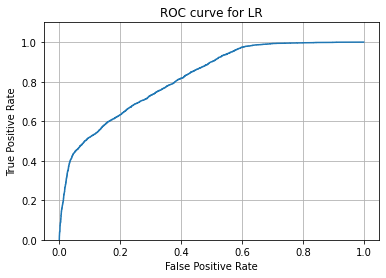

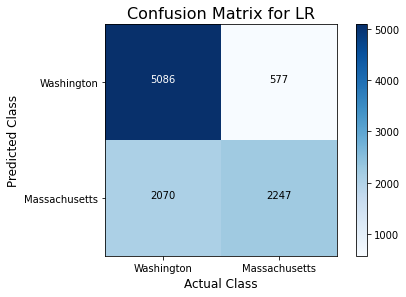

In [29]:
best_lr = LogisticRegression(random_state=0, solver='liblinear', C=1.0, penalty='l1')
best_clf_plot(best_lr, 'lr')

              precision    recall  f1-score   support

           0       0.71      0.83      0.77      5663
           1       0.72      0.56      0.63      4317

    accuracy                           0.71      9980
   macro avg       0.71      0.70      0.70      9980
weighted avg       0.71      0.71      0.71      9980

[[4712  951]
 [1908 2409]]


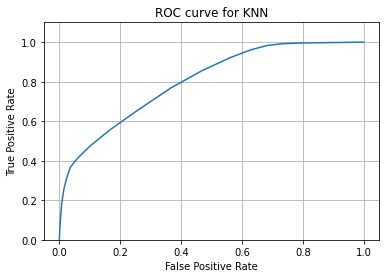

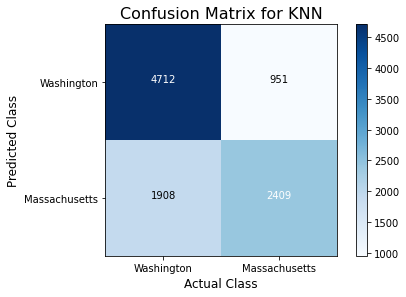

In [15]:
best_knn = KNeighborsClassifier(n_neighbors=16)
best_clf_plot(best_knn, 'knn')

              precision    recall  f1-score   support

           0       0.68      0.78      0.72      5663
           1       0.64      0.52      0.57      4317

    accuracy                           0.66      9980
   macro avg       0.66      0.65      0.65      9980
weighted avg       0.66      0.66      0.66      9980

[[4394 1269]
 [2084 2233]]


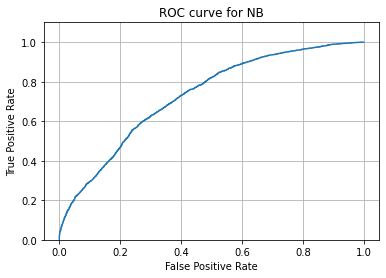

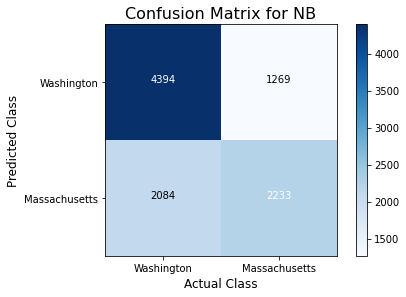

In [16]:
best_nb = GaussianNB(var_smoothing=1e-08)
best_clf_plot(best_nb, 'nb')

              precision    recall  f1-score   support

           0       0.70      0.92      0.80      5663
           1       0.83      0.49      0.62      4317

    accuracy                           0.74      9980
   macro avg       0.77      0.71      0.71      9980
weighted avg       0.76      0.74      0.72      9980

[[5235  428]
 [2193 2124]]


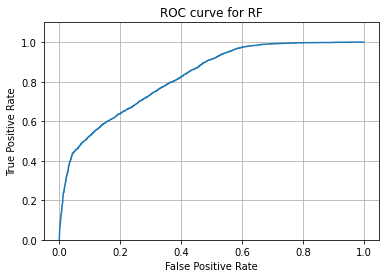

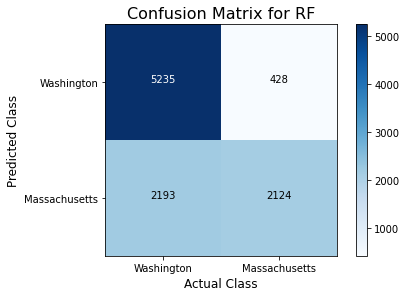

In [17]:
best_rf = RandomForestClassifier(random_state=0, criterion='gini', max_depth=9, max_features='auto', n_estimators=125)
best_clf_plot(best_rf, 'rf')

              precision    recall  f1-score   support

           0       0.72      0.89      0.80      5663
           1       0.79      0.55      0.65      4317

    accuracy                           0.74      9980
   macro avg       0.75      0.72      0.72      9980
weighted avg       0.75      0.74      0.73      9980

[[5013  650]
 [1930 2387]]


C:\Users\ericz\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


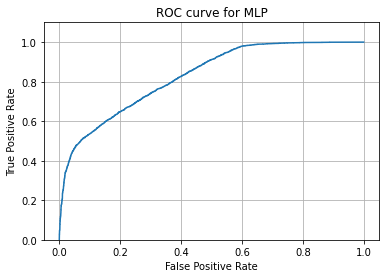

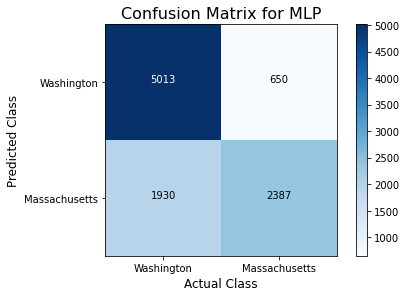

In [22]:
best_mlp = MLPClassifier(random_state=0, activation='relu', alpha=0.001, hidden_layer_sizes=26, max_iter=50, solver='adam')
best_clf_plot(best_mlp, 'mlp')

              precision    recall  f1-score   support

           0       0.70      0.93      0.80      5663
           1       0.84      0.47      0.61      4317

    accuracy                           0.73      9980
   macro avg       0.77      0.70      0.70      9980
weighted avg       0.76      0.73      0.72      9980

[[5284  379]
 [2275 2042]]


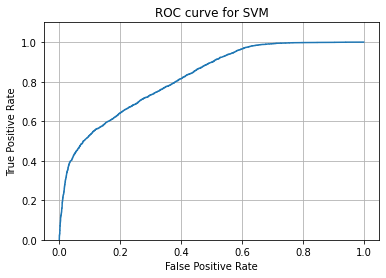

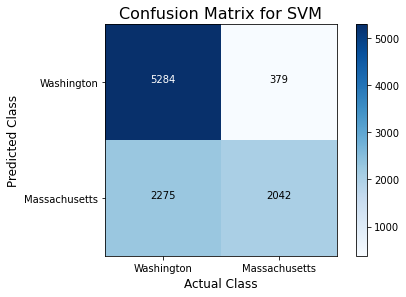

In [21]:
best_svm = svm.SVC(probability=True, random_state=0, gamma=1)
best_clf_plot(best_svm, 'svm')